# 1. Introuction

 This notebook outlines the creation, compilation, and training of a Swin Tranformer network to classify 101 (+unknown) types of food. To this end, the **distillation technique** is applied to learn from a larger, pre-trained transformer model, especifically, a ViT-Base/16-384 transformer.
 
 An extra class called "unknown" was created using images from the [iFood-2019 dataset](https://www.kaggle.com/competitions/ifood-2019-fgvc6/data) that contains 251 food types. As in the other trained models, PyTorch's pretrained weights will be used to initialize the models and no transfer learning will be applied. 

# 2. Importing Libraries

In [1]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import pandas as pd
import numpy as np
import shutil

from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

#from warmup_scheduler_pytorch import WarmUpScheduler
#from timm.scheduler.cosine_lr import CosineLRScheduler

# Import custom libraries
from modules.helper_functions import set_seeds, display_random_images
from modules.engine import DistillationEngine, Common
from modules.schedulers import FixedLRSchedulerWrapper
from modules.dataloaders import create_dataloaders
from modules.loss_functions import DistillationLoss
#from modules.scheduler import WarmupCosineAnnealingLR


# Define some constants
NUM_WORKERS = os.cpu_count()
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"
UNKNOWN_DIR_NAME = f"../data/food-101_100_percent_unknown_2"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

import warnings
os.environ['TORCH_USE_CUDA_DSA'] = "1"
warnings.filterwarnings("ignore", category=UserWarning, module="torch.autograd.graph")
warnings.filterwarnings("ignore", category=FutureWarning, module="onnxscript.converter")

# 3. Specifying Target Device

In [2]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Tue Feb 11 20:36:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   53C    P8             11W /  200W |    1232MiB /  12282MiB |      3%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 4. Image Visualization

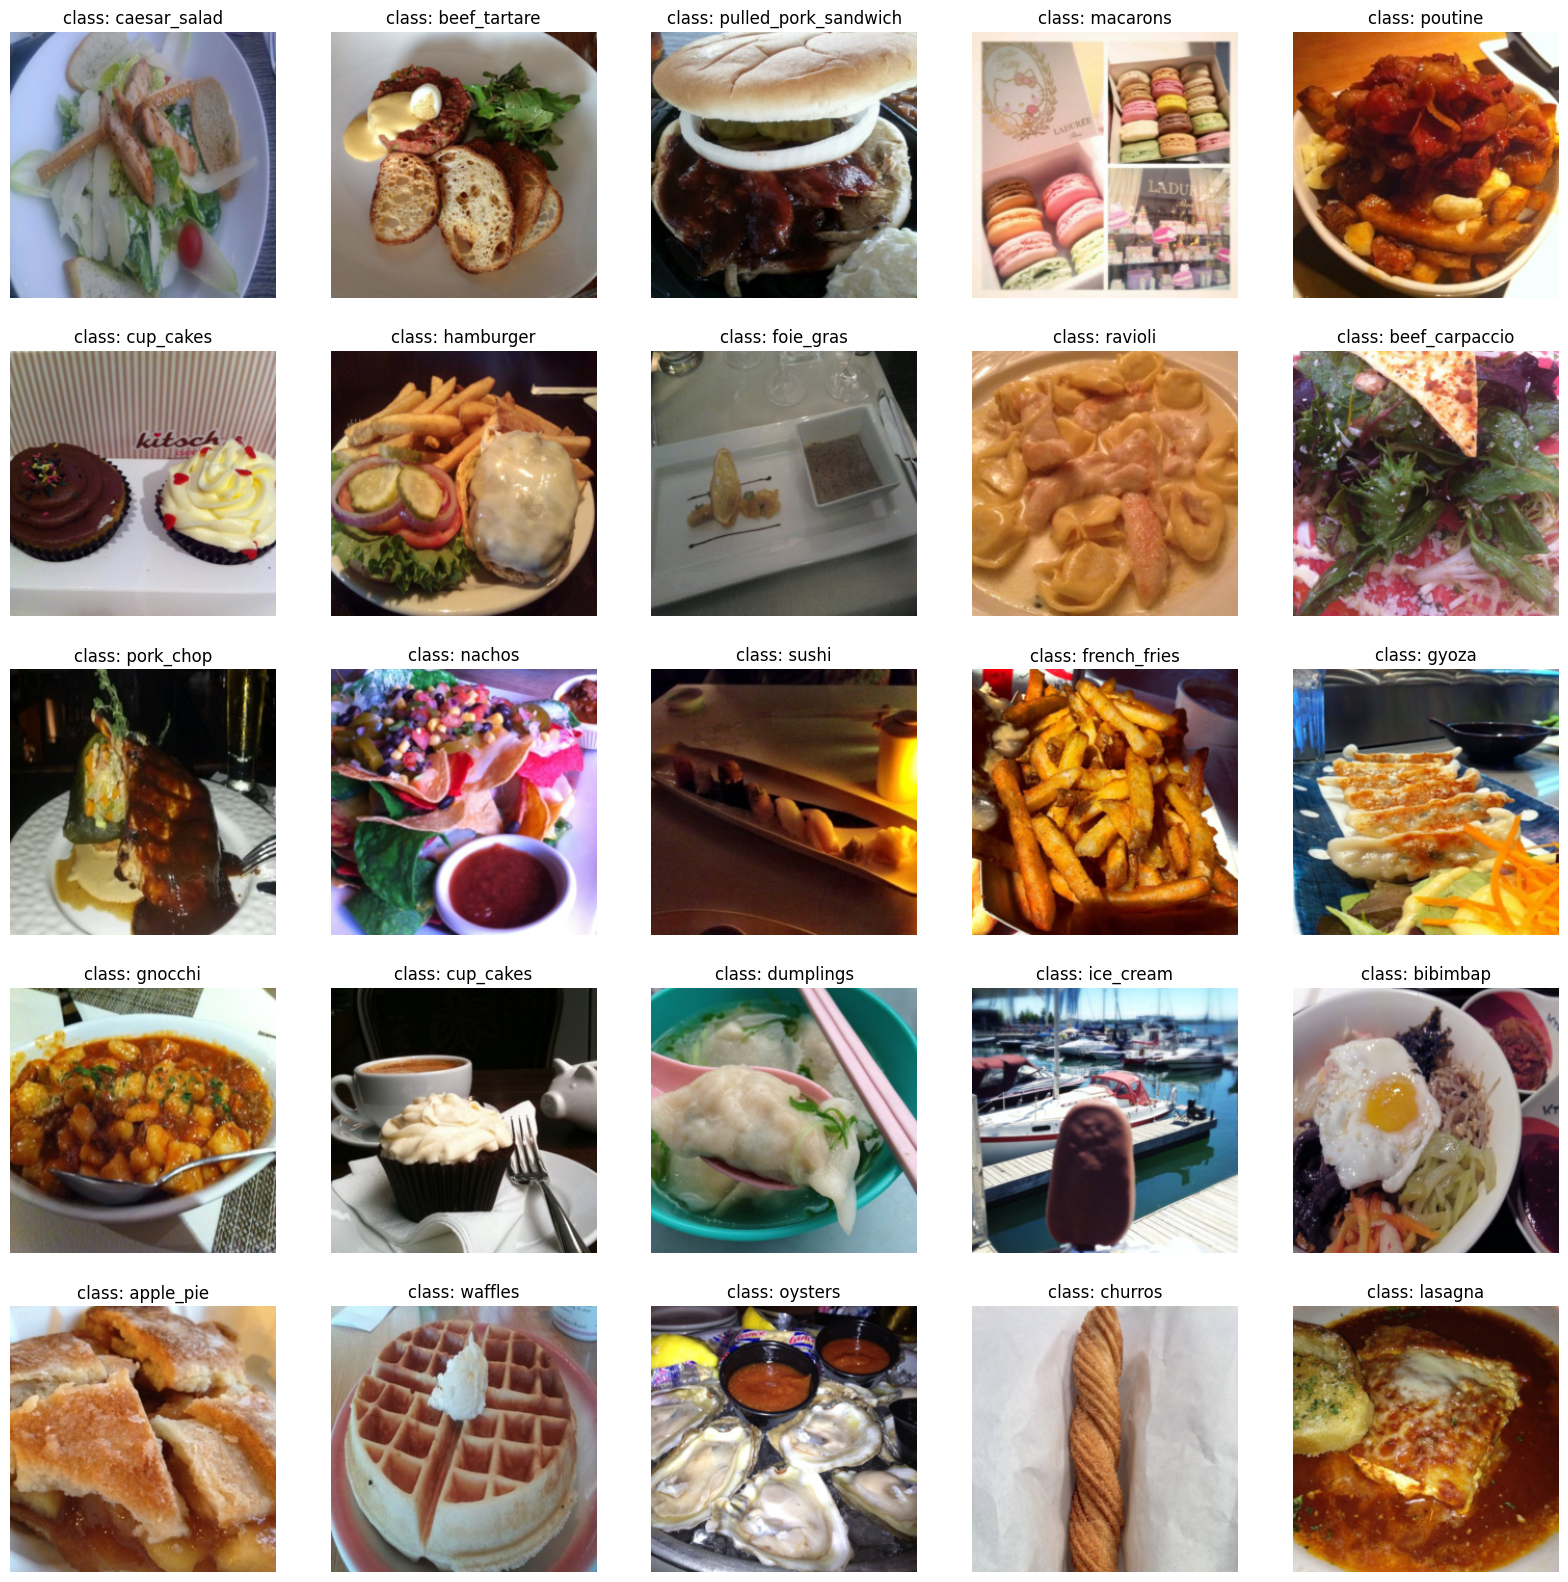

In [3]:
# Display images
manual_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomCrop((256, 256)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_data = datasets.ImageFolder(TRAIN_DIR, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=train_data.classes,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 5. Create Teacher - 102 Classes

In [4]:
# Copy the unknown class into the dataset
shutil.copytree(UNKNOWN_DIR_NAME, TARGET_DIR_NAME, dirs_exist_ok=True)

'../data/food-101_100_percent'

In [5]:
# Specify transformations
IMG_SIZE_TCH = 384
BATCH_SIZE = 16

transform_train_tch = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((IMG_SIZE_TCH)),
    v2.CenterCrop((IMG_SIZE_TCH, IMG_SIZE_TCH)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

transform_test_tch = v2.Compose([    
    v2.Resize((IMG_SIZE_TCH)),
    v2.CenterCrop((IMG_SIZE_TCH, IMG_SIZE_TCH)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

# Create data loaders
train_dataloader_tch, test_dataloader_tch, class_names = create_dataloaders(
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=transform_train_tch,
    test_transform=transform_test_tch,
    batch_size=BATCH_SIZE
)

# Load ViT-Base/16-384 
model_tch_type="vitbase16_102_2025-01-27"
model_tch_name = model_tch_type + "_epoch19.pth"

# Instantiate the model
model_tch = torchvision.models.vit_b_16(image_size=IMG_SIZE_TCH).to(device)
model_tch.heads = torch.nn.Linear(in_features=768, out_features=len(class_names)).to(device)
model_tch = torch.compile(model_tch, backend="aot_eager")

# Load the trained weights
model_tch = Common.load_model(
    model=model_tch,
    target_dir=MODEL_DIR,
    model_name=model_tch_name)

# Print summary
#summary(model_tch,
#        input_size=(BATCH_SIZE,3,IMG_SIZE_TCH, IMG_SIZE_TCH), # try swapping this for "random_input_image_error"
#        col_names=["input_size", "output_size", "num_params", "trainable"],
#        col_width=20,
#        row_settings=["var_names"])

[INFO] Loading model from: ..\models\vitbase16_102_2025-01-27_epoch19.pth


# 5. Create Student - 102 Classes

In [6]:
# Specify transformations
IMG_SIZE_STD = 256
BATCH_SIZE = 16

transform_train_std = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((260)),
    v2.RandomCrop((IMG_SIZE_STD, IMG_SIZE_STD)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

transform_test_std = v2.Compose([    
    v2.Resize((260)),
    v2.CenterCrop((IMG_SIZE_STD, IMG_SIZE_STD)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

# Create data loaders
train_dataloader_std, test_dataloader_std, class_names = create_dataloaders(
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=transform_train_std,
    test_transform=transform_test_std,
    batch_size=BATCH_SIZE
)


# Copy weights from torchvision.models
set_seeds(SEED)

# Instantiate the model
model_std = torchvision.models.swin_v2_t(weights=torchvision.models.Swin_V2_T_Weights.DEFAULT)
model_std.head = torch.nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Unfreeze the base parameters
for parameter in model_std.parameters():
    parameter.requires_grad = True

# Compile model
model_std = torch.compile(model_std, backend="aot_eager")

# Print summary
#summary(model_std,
#        input_size=(BATCH_SIZE,3,IMG_SIZE_STD, IMG_SIZE_STD), # try swapping this for "random_input_image_error"
#        col_names=["input_size", "output_size", "num_params", "trainable"],
#        col_width=20,
#        row_settings=["var_names"])

Epoch: 28/30 | Train: | loss: 0.8364 | acc: 0.9575 | fpr: 0.1974 | pauc: 0.0496 | time:  32m51s | lr: 0.0000010000
Epoch: 28/30 | Test:  | loss: 0.4682 | acc: 0.9175 | fpr: 0.3668 | pauc: 0.0485 | time:   7m56s | lr: 0.0000010000


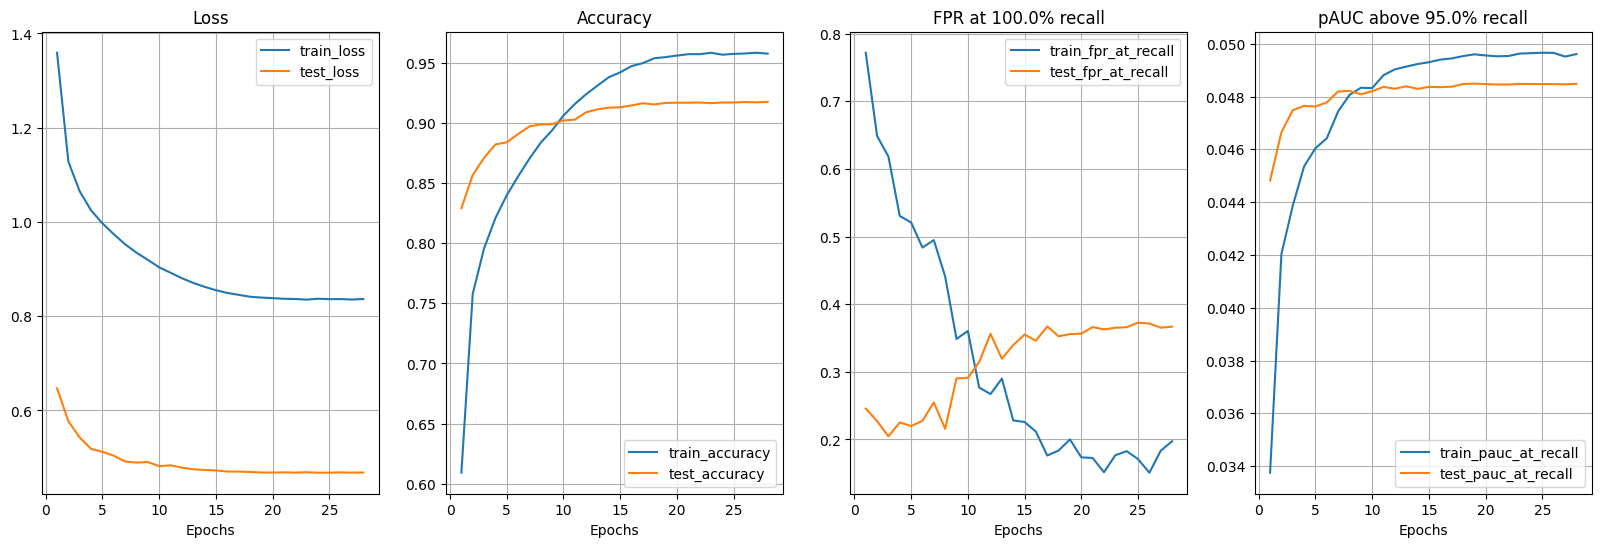

[INFO] Saving model to: ..\models\swinv2tiny_102_2025-02-08_epoch28.pth
[INFO] Saving model to: ..\models\swinv2tiny_102_2025-02-08_acc_epoch28.pth
[INFO] Training epoch 29...


  0%|          | 0/4782 [00:00<?, ?it/s]

RuntimeError: Caught RuntimeError in DataLoader worker process 12.
Original Traceback (most recent call last):
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\utils\data\_utils\worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\utils\data\_utils\collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\utils\data\_utils\collate.py", line 211, in collate
    return [
           ^
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\utils\data\_utils\collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\utils\data\_utils\collate.py", line 159, in collate
    return collate_fn_map[collate_type](
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\utils\data\_utils\collate.py", line 270, in collate_tensor_fn
    storage = elem._typed_storage()._new_shared(numel, device=elem.device)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\storage.py", line 1180, in _new_shared
    untyped_storage = torch.UntypedStorage._new_shared(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torch\storage.py", line 400, in _new_shared
    return cls._new_using_filename_cpu(size)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Couldn't open shared file mapping: <torch_31192_1838192895_10>, error code: <1455>


In [7]:
# Train the model
model_std_type="swinv2tiny_102_2025-02-08"
model_std_name = model_std_type + ".pth"

# Epochs and learning rate
EPOCHS = 30
LR = 0.0001

# Create optimizer
optimizer = torch.optim.AdamW(
    params=model_std.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = DistillationLoss(alpha=0.4, temperature=2, label_smoothing=0.1)

# Initialize the scheduler
#scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=eta_min)
scheduler = FixedLRSchedulerWrapper(
    scheduler=CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6),
    fixed_lr=1e-6,
    fixed_epoch=20)

# Set seeds
set_seeds(SEED)

# And train...
engine = DistillationEngine(
    student=model_std,
    teacher=model_tch,
    device=device)

results = engine.train(
    target_dir=MODEL_DIR,
    model_name=model_std_name,
    save_best_model=["last", "loss", "acc"],
    keep_best_models_in_memory=False,
    train_dataloader_std=train_dataloader_std,
    train_dataloader_tch=train_dataloader_tch,
    test_dataloader_std=test_dataloader_std,
    test_dataloader_tch=test_dataloader_tch,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=1.0,
    recall_threshold_pauc=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=4
    )

In [ ]:
results